# Working Example

In [1]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd
import pupil_labs.video as plv
from utils import VideoHandler, write_worldtimestamp_csv
from optic_flow import OpticFlowCalculatorLK
from sync_videos import OffsetCalculator
from gaze_mapper import ActionCameraGazeMapper 

Given a Neon Video recording (from the Scene Video + Timeseries) and its corresponding Action Camera recording:

In [2]:
action_vid_path='/users/sof/gaze_mapping/raw_videos/InstaVid/wearingNeon_2m/AVun_20240216_160246_055.mp4'
neon_vid_path='/users/sof/gaze_mapping/raw_videos/Neon/Raw_Data/2024-02-16_wearingNeon/2024-02-16_15-58-13-6310bec3/cc00c32d_0.0-146.071.mp4'

## Step 1: Obtain Optic Flow

There are two different optic_flow classes: one using Lucas-Kanade method (sparse-gridlike optic flow)and another one using  Gunnar Farneback method (dense, pixel-wise optic flow).

Lukas Kanade is way faster than the Gunnar Farneback Method, so this notebook will run with this method (For a 2min video it takes around ~3min)

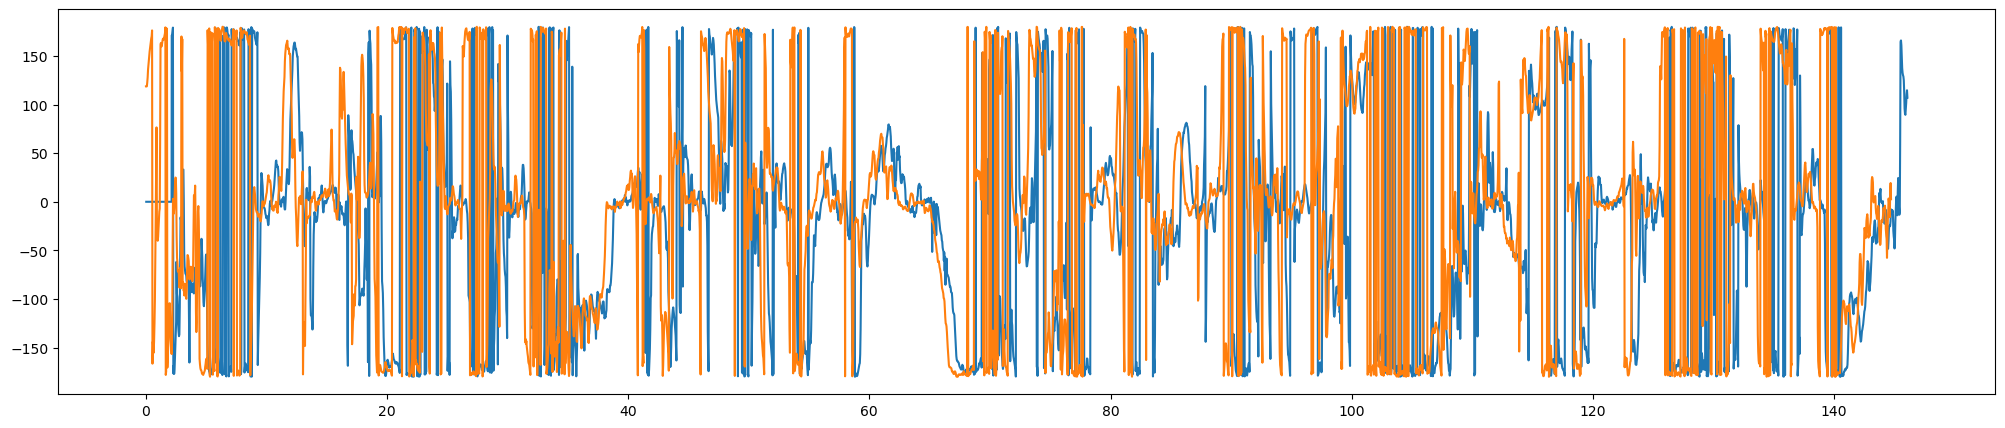

In [3]:
action_of = OpticFlowCalculatorLK(video_dir=action_vid_path)
neon_of = OpticFlowCalculatorLK(video_dir=neon_vid_path)

neon_result = neon_of.get_all_optic_flow()
action_result = action_of.get_all_optic_flow()

plt.figure(figsize=(25,5)) 
plt.plot(neon_result['end'].values,np.rad2deg(neon_result['angle'].values),label='neon')
plt.plot(action_result['end'].values,np.rad2deg(action_result['angle'].values),label='action')

With the write_to_csv method, the optic flow results are saved to a csv file in a user indicated address. The csv file will contain the following columns:
- start: the start frame timestamp of the optic flow calculation
- end: the end frame timestamp of the optic flow calculation
- angle
- avg_displacement_x
- avg_displacement_y

In [7]:
name=Path(action_vid_path).parent.name
print(name)
Path(f'/users/sof/optic_flow/{name}').mkdir(parents=True, exist_ok=True)
action_of.write_to_csv(f'/users/sof/optic_flow/{name}/{name}_action_lk_of.csv')
neon_of.write_to_csv(f'/users/sof/optic_flow/{name}/{name}_neon_lk_of.csv')

wearingNeon_2m


## Step 2: Estimate time offset between videos

After optic flow is calculated, the OffsetCalculator class obtains the time offset of the action video with respect to the neon scene video. Optionally one can also indicate a period of time of the action (source) optic flow signal, to be matched to the whole neon (destination) signal 


Estimated offset: 0.63 seconds (Pearson correlation: 0.6587040303503877)


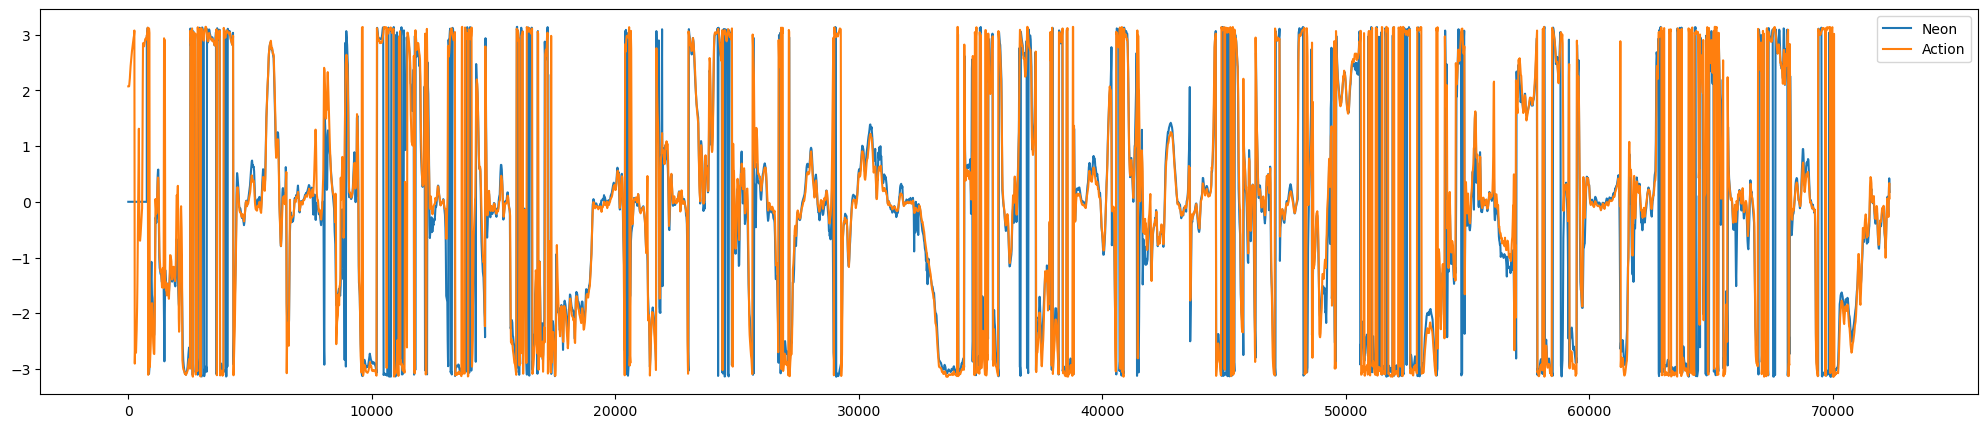

In [8]:
offset_calc=OffsetCalculator(source=action_result['angle'].values,source_timestamps=action_result['start'].values, destination=neon_result['angle'].values, destination_timestamps=neon_result['start'].values,resampling_frequency=500)
t_offset, pearson_corr = offset_calc.estimate_time_offset()
print(f'Estimated offset: {t_offset} seconds (Pearson correlation: {pearson_corr})')

start,end = None,None
idx=offset_calc._obtain_indexes(offset_calc.source_resampled_timestamps,start,end)
x_cor,lags=offset_calc._cross_correlate(offset_calc.source_resampled[idx[0]:idx[1]])
s_offset = lags[np.argmax(x_cor)]
s,d=offset_calc._obtain_overlapping_signals(s_offset,offset_calc.source_resampled[idx[0]:idx[1]])
plt.figure(figsize=(25,5))
plt.plot(d,label='Neon')
plt.plot(s, label='Action')
plt.legend()


Estimated offset: 0.6299999999999999 seconds (Pearson correlation: 0.7926304995994305)


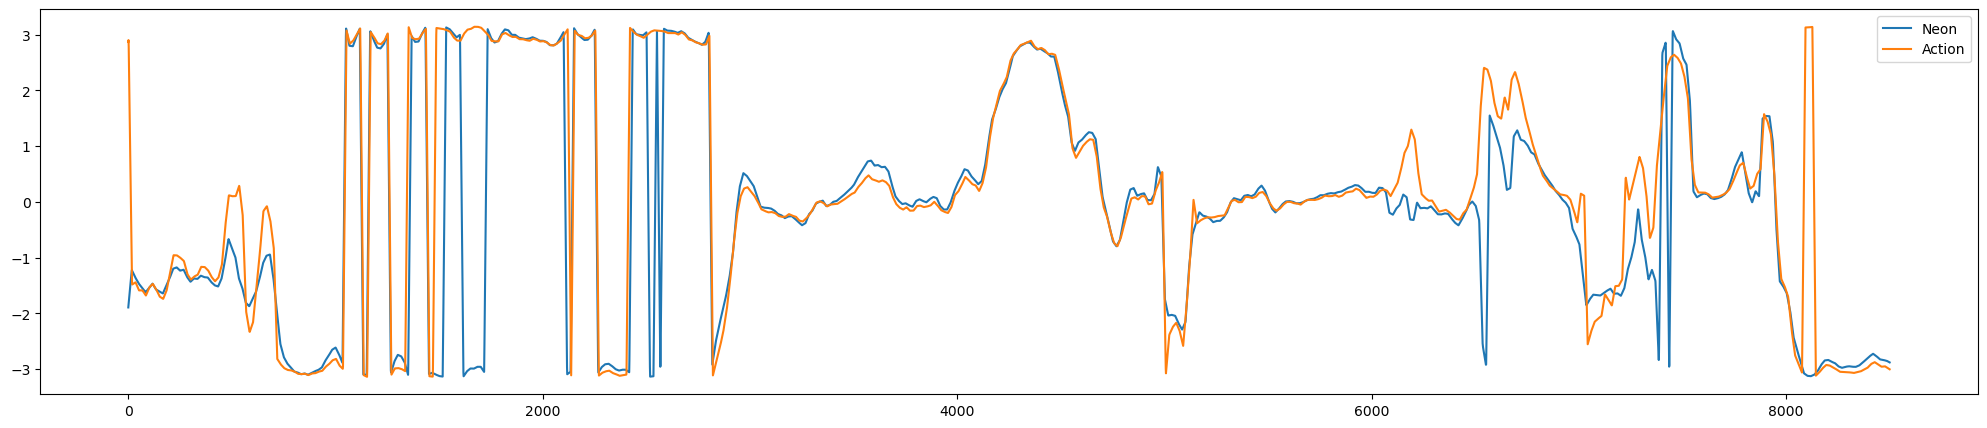

In [9]:
start,end = 3,20
t_offset,pearson_corr = offset_calc.estimate_time_offset(source_end_time=end, source_start_time=start)
print(f'Estimated offset: {t_offset} seconds (Pearson correlation: {pearson_corr})')
idx=offset_calc._obtain_indexes(offset_calc.source_resampled_timestamps,start,end)
x_cor,lags=offset_calc._cross_correlate(offset_calc.source_resampled[idx[0]:idx[1]])
s_offset = lags[np.argmax(x_cor)]
s,d=offset_calc._obtain_overlapping_signals(s_offset,offset_calc.source_resampled[idx[0]:idx[1]])
plt.figure(figsize=(25,5))
plt.plot(d,label='Neon')
plt.plot(s, label='Action')
plt.legend()

## Step 3: Creation of action_worldtimestamps.csv

Once calculated the time offset, the action_worldtimestamps.csv can be generated with the function write_worldtimestamp_csv. This function wirtes the csv to the same directory as the given world_timestamps.csv from Neon

In [7]:
actionVid=VideoHandler(action_vid_path)
neon_timestamps= str(Path(neon_vid_path).parent / 'world_timestamps.csv')
write_worldtimestamp_csv(world_timestamps_dir=neon_timestamps, relative_timestamps=actionVid.timestamps, time_delay=t_offset)

World timestamps for action camera recording saved at /users/sof/gaze_mapping/raw_videos/Neon/Raw_Data/2024-02-16_wearingNeon/2024-02-16_15-58-13-6310bec3/action_camera_world_timestamps.csv


## Step 4: Map gaze data to the action video

In [ ]:
param={'location':'indoor', 'gpu_num':0}
neon_timestamps= str(Path(neon_vid_path).parent / 'world_timestamps.csv')
action_timestamps= neon_timestamps.replace('world_timestamps.csv','action_camera_world_timestamps.csv')
neon_gaze_csv=neon_timestamps.replace('world_timestamps.csv','gaze.csv')
name=Path(action_vid_path).parent.name
action_vid_path='/users/sof/gaze_mapping/raw_videos/InstaVid/wearingNeon_2m/AVun_20240216_160246_055.mp4'
neon_vid_path='/users/sof/gaze_mapping/raw_videos/Neon/Raw_Data/2024-02-16_wearingNeon/2024-02-16_15-58-13-6310bec3/cc00c32d_0.0-146.071.mp4'

mapper = ActionCameraGazeMapper(neon_gaze_csv=neon_gaze_csv,
        neon_video_dir=neon_vid_path,
        action_video_dir=action_vid_path,
        neon_worldtimestamps=neon_timestamps,
        action_worldtimestamps=action_timestamps,
        image_matcher='loftr',
        image_matcher_parameters=param,
        neon_opticflow_csv=f'/users/sof/optic_flow/{name}_neon_lk_of.csv',
        action_opticflow_csv=f'/users/sof/optic_flow/{name}_action_lk_of.csv',
        patch_size=1000)

In [ ]:
Path(f'/users/sof/gaze_mapping/mapped_gaze/{name}').mkdir(parents=True, exist_ok=True)
mapper.map_gaze(saving_path=f'/users/sof/gaze_mapping/mapped_gaze/{name}/{name}_gaze_mapping.csv')